In [2]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Rescaling, Conv2D, \
                                    Dropout, MaxPooling2D,\
                                    Flatten, Dense, ReLU, Lambda

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)
    
!nvidia-smi

Mon Feb 19 13:47:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0              27W / 250W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
width = 200
height = 150
channels = 1
input_shape = (height, width, channels)

## Load image pairs dataset

In [5]:
def load_data():
    X = np.load("/kaggle/input/signatures-numpy-no-split/X.npy")
    print(X.shape)
    y = np.load("/kaggle/input/signatures-numpy-no-split/y.npy")
    print(y.shape)

    X_t, X_test, y_t, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    print(X_t.shape)
    print(y_t.shape)
    print(X_test.shape)
    print(y_test.shape)

    del X
    del y

    X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size = 0.2, random_state = 42)
    print(X_train.shape)
    print(y_train.shape)
    print(X_val.shape)
    print(y_val.shape)

    del X_t
    del y_t

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_data()

(30360, 2, 150, 200)
(30360,)
(21252, 2, 150, 200)
(21252,)
(9108, 2, 150, 200)
(9108,)
(17001, 2, 150, 200)
(17001,)
(4251, 2, 150, 200)
(4251,)


## Data visualization

In [6]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    
    for i in range(to_show):
        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]
        
        n = random.randint(0, pairs.shape[0])
        print(f"Index to show: {n}")
        ax.imshow(np.concatenate([pairs[n][0], pairs[n][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[n], predictions[n][0]))
        else:
            ax.set_title("Label: {}".format(labels[n]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()


### Visualize train data

Index to show: 14907
Index to show: 6390
Index to show: 11902
Index to show: 3863


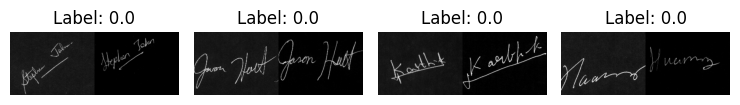

In [7]:
visualize(X_train[:-1], y_train[:-1], to_show = 4, num_col = 4)

### Visualize validation data

Index to show: 4011
Index to show: 3121
Index to show: 1200
Index to show: 64


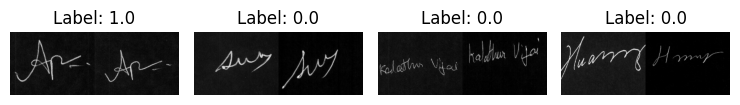

In [8]:
visualize(X_val[:-1], y_val[:-1], to_show = 4, num_col = 4)

### Visualize test data

Index to show: 931
Index to show: 4007
Index to show: 7818
Index to show: 4267


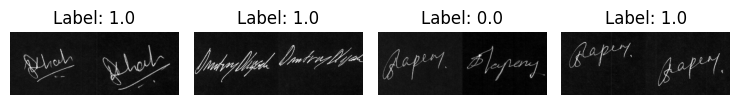

In [9]:
visualize(X_test[:-1], y_test[:-1], to_show = 4, num_col = 4)

## Siamese Network

In [10]:
def siamese_network(input_shape):
    input = Input(input_shape)

    x = Rescaling(1/255)(input)

    x = Conv2D(64, (11, 11), activation = "relu")(input)
    x = Lambda(tf.nn.local_response_normalization)(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)

    x = Conv2D(128, (7, 7), activation = "relu")(x)
    x = Lambda(tf.nn.local_response_normalization)(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (5, 5), activation = "relu")(x)

    x = Conv2D(512, (3, 3), activation = "relu")(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Dropout(0.3)(x)

    x = Dense(1024, activation = "relu")(x)
    x = Dropout(0.5)(x)

    x = Flatten()(x)

    x = Dense(128, activation = "relu")(x)

    model = Model(input, x)

    return model

def euclidean_distance(vecs):
    (imgA, imgB) = vecs
    sum_square = K.sum(K.square(imgA - imgB), axis = 1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [11]:
imageA = Input(input_shape)
imageB = Input(input_shape)

siamese = siamese_network(input_shape)

modelA = siamese(imageA)
modelB = siamese(imageB)

distance = Lambda(euclidean_distance, output_shape=(1,))([modelA, modelB])

output = Dense(1, activation = "sigmoid")(distance)

model = Model(inputs = [imageA, imageB], outputs = output)

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 200, 1)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 150, 200, 1)]        0         []                            
                                                                                                  
 model (Functional)          (None, 128)                  3530918   ['input_1[0][0]',             
                                                          4          'input_2[0][0]']             
                                                                                                  
 lambda_2 (Lambda)           (None, 1)                    0         ['model[0][0]',         

### Fit a new model

In [12]:
batch_size = 64
epochs = 20
early_stopping = EarlyStopping(monitor = "val_loss", patience = 5, verbose = 1)

history = model.fit([X_train[:, 0, :, :], X_train[:, 1, :, :]], y_train,
                    validation_data = ([X_val[:, 0, :, :], X_val[:, 1, :, :]], y_val),
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = [early_stopping],
                    verbose = 1)

Epoch 1/20


2024-02-19 13:50:38.649277: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1708350647.751799     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


266/266 [==============================] - 227s 793ms/step - loss: 0.3286 - accuracy: 0.9579 - val_loss: 0.3155 - val_accuracy: 0.9725
Epoch 2/20
266/266 [==============================] - 216s 812ms/step - loss: 0.2683 - accuracy: 0.9926 - val_loss: 0.2387 - val_accuracy: 0.9984
Epoch 3/20
266/266 [==============================] - 216s 812ms/step - loss: 0.2172 - accuracy: 0.9992 - val_loss: 0.1992 - val_accuracy: 0.9984
Epoch 4/20
266/266 [==============================] - 216s 812ms/step - loss: 0.1827 - accuracy: 0.9986 - val_loss: 0.1695 - val_accuracy: 0.9967
Epoch 5/20
266/266 [==============================] - 216s 812ms/step - loss: 0.1597 - accuracy: 0.9948 - val_loss: 0.1427 - val_accuracy: 0.9979
Epoch 6/20
266/266 [==============================] - 216s 811ms/step - loss: 0.1443 - accuracy: 0.9915 - val_loss: 0.1234 - val_accuracy: 0.9974
Epoch 7/20
266/266 [==============================] - 216s 811ms/step - loss: 0.1109 - accuracy: 0.9995 - val_loss: 0.1032 - val_accura

### Load a pre-trained model

In [ ]:
model = load_model('')

## Plot loss and accuracy

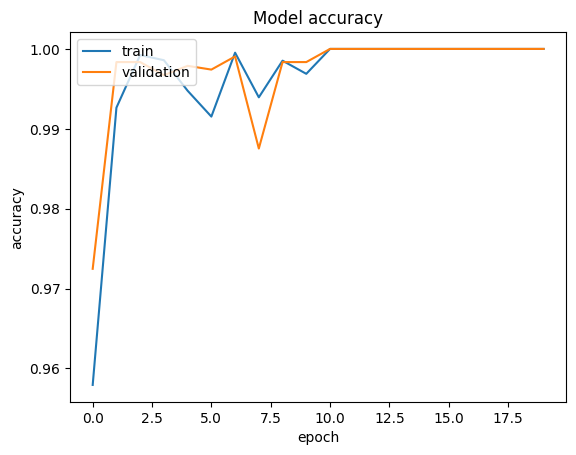

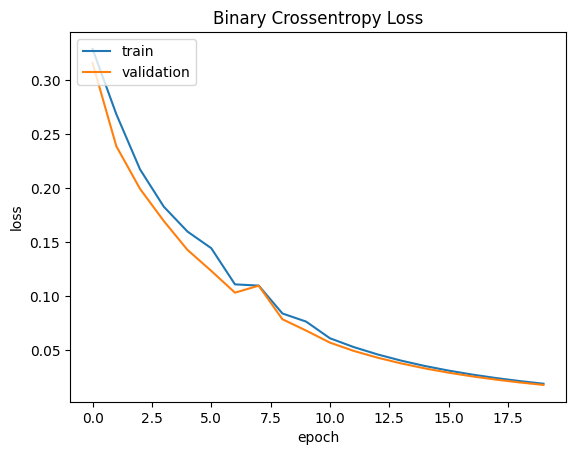

In [13]:
def plt_metric(history, metric, title, has_valid=True):
    
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the loss
plt_metric(history=history.history, metric="loss", title="Binary Crossentropy Loss")


## Evaluation and predictions on test data

In [15]:
results = model.evaluate([X_test[:, 0, :, :], X_test[:, 1, :, :]], y_test)
print("test loss, test acc:", results)

285/285 [==============================] - 35s 113ms/step - loss: 0.0183 - accuracy: 1.0000
test loss, test acc: [0.01827937364578247, 1.0]


285/285 [==============================] - 30s 104ms/step
Index to show: 216
Index to show: 7474
Index to show: 5643


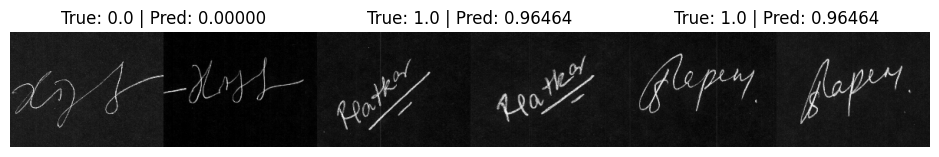

In [16]:
predictions = model.predict([X_test[:, 0, :, :], X_test[:, 1, :, :]])
visualize(X_test[:-1], y_test[:-1], to_show=3, predictions=predictions, test=True)

## Save the model

In [14]:
model.save("/kaggle/working/signatures_siamese_64_512_lrn_bcrloss_v2.keras")

## Feature maps visualization

In [17]:
siamese.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 200, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 140, 190, 64)      7808      
                                                                 
 lambda (Lambda)             (None, 140, 190, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 70, 95, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 89, 128)       401536    
                                                                 
 lambda_1 (Lambda)           (None, 64, 89, 128)       0         
                                                             

In [18]:
for i in range(len(siamese.layers)):
    layer = siamese.layers[i]
    if "conv" not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)

1 conv2d (None, 140, 190, 64)
4 conv2d_1 (None, 64, 89, 128)
8 conv2d_2 (None, 28, 40, 256)
9 conv2d_3 (None, 26, 38, 512)


In [19]:
index = [1, 4, 8, 9]
outputs = [siamese.layers[i].output for i in index]
visualize_net = Model(inputs = siamese.inputs, outputs = outputs)
visualize_net.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 200, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 140, 190, 64)      7808      
                                                                 
 lambda (Lambda)             (None, 140, 190, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 70, 95, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 89, 128)       401536    
                                                                 
 lambda_1 (Lambda)           (None, 64, 89, 128)       0         
                                                           

In [20]:
print(X_train[0][0].shape)
img = np.expand_dims(X_train[0][0], axis = 0)
print(img.shape)

(150, 200)
(1, 150, 200)


In [21]:
feature_maps = visualize_net.predict(img)

1/1 [==============================] - 0s 228ms/step


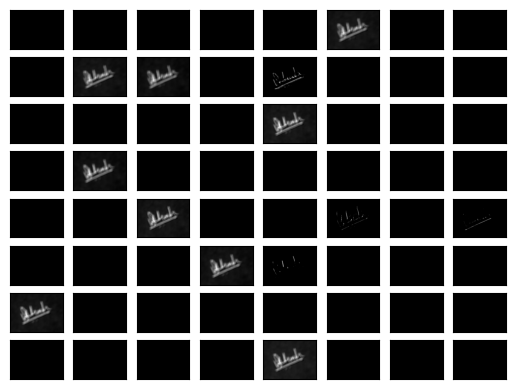

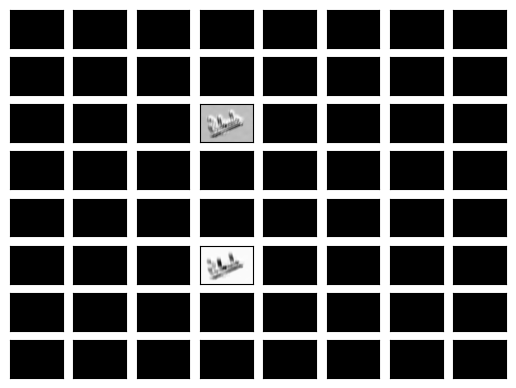

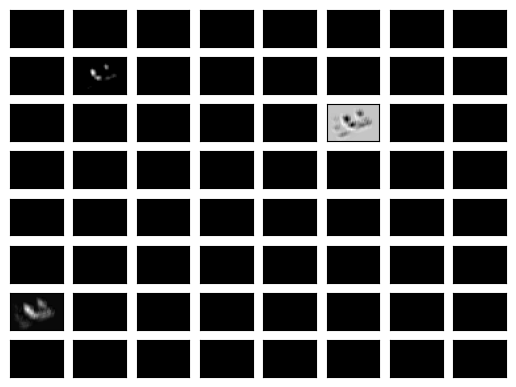

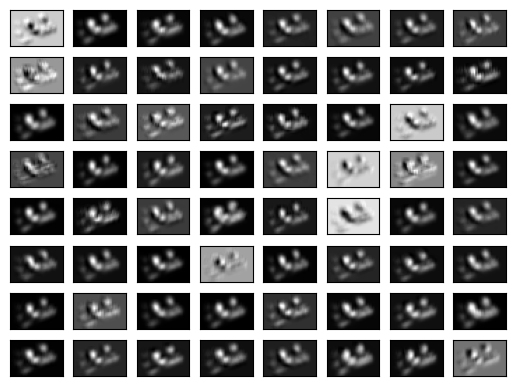

In [22]:
square = 8
for fmap in feature_maps:
    index = 1
    for _ in range(square):
        for _ in range(square):
            ax = plt.subplot(square, square, index)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(fmap[0, :, :, index-1], cmap = "gray")
            index += 1
    plt.show()